<a href="https://colab.research.google.com/github/kscaman/MAP583/blob/main/TP/TP08_DeepRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP08 - Playing Atari games with deep reinforcement learning

In this practical, our objective is to replicate the famous [Deepmind paper on DQN](https://deepmind.google/discover/blog/deep-reinforcement-learning/) and train, using deep Q learning, an agent to play the Atari game [Breakout](https://www.gymlibrary.dev/environments/atari/breakout/)
The code is adapted from the following [Github repo](https://github.com/jacobaustin123/pytorch-dqn/) and the [Pytorch tutorial on DQL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).


In [ ]:
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install ale-py
#!pip install --upgrade ipykernel

import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython import display
from IPython.display import HTML
from tqdm import tqdm
import ale_py


!pip install --quiet "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import TP08
TP08.check_install()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446673 sha256=7d97eab7dbbaa2f79bacb829537b79eb36bc27131729bae2611c412b2d7d5bf7
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


# Part A - Creating the environment
First load the environment using `env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")` (you can search the [gym documentation](https://ale.farama.org/environments/breakout/)). Initialize the environment through `env.reset()`. Check the `env.observation_space` and the `env.action_space` attributes of the environment.

In [ ]:
### YOUR CODE HERE ###

Try to understand how the actions impact the environment. Using `env.step(action)` generate a new state, and display it using imshow. Check the documentation [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step). Print the reward associated to your actions.

In [ ]:
### YOUR CODE HERE ###

Define a function called `policy` that takes as input a state and returns an action, using `env.action_space.sample()`. Using TP08.create_video(env, policy,use_gymnasium=True), create a video of a random agent playing Breakout.

In [ ]:
### YOUR CODE HERE ###

Create a class `EpsilonGreedy(model, epsilon)` that takes a model and returns its corresponding epsilon greedy policy. To do so, create a method `__call__(self, state)` that returns a random action with probability epsilon, and the action chosen by the model otherwise (i.e. the action with maximum score, where `model(states)` is a tensor of shape (1,num_actions)). Note that the output of the method should be an integer.

Finally, create a video of an epsilon-greedy strategy that goes left expect with probability $\varepsilon = 0.5$.

In [ ]:
### YOUR CODE HERE ###

# Part B - State pre-processing
We would like to simplify the learning task by pre-processing the frames in two ways: 1) image pre-processing and 2) using frame sequences.

1) The atari frame is large and contains scores at the top of the screen that is not useful for our agent (as a reward is already available). Using `torchvision.transforms` methods (`ToPILImage`, `Grayscale`, `Resize`, `functional.crop`), we first crop and resize the image to a $84\times 84$ grayscale image. Test this preprocessing on an Atari frame.

In [ ]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Grayscale(),
    lambda x : torchvision.transforms.functional.crop(x, 25, 8, 180, 144),
    torchvision.transforms.Resize((84, 84), 0),
    torchvision.transforms.ToTensor()
])

### YOUR CODE HERE ###

To allow our model to access the speed and direction of the ball, we will augment the state of the environment by storing a sequence of 4 consecutive frames.

In [ ]:
class Preprocessing:
    def __init__(self):
        self.history = torch.zeros((4, 84, 84))

    def __call__(self, state):
        self.history = torch.cat([self.history[1:], img_transform(state)])
        return self.history.unsqueeze(0).to(device)

preprocess = Preprocessing()
env.reset()
[env.step(env.action_space.sample()) for _ in range(50)]
print(preprocess(env.render()).shape)

# Part C - Deep Q Learning algorithm
## C.1 - Creating the model
We are now going to implement the DQN algorithm. First, we need to encode the policy using a neural network. The following code create a convolutional neural network that takes a sequence of 4 frames from the game and returns a score for each possible action. The CNN consists of 3 convolution layers `nn.Conv2d(4, 32, 8, stride=4), nn.Conv2d(32, 64, 4, stride=2), nn.Conv2d(64, 64, 3, stride=1)` followed by an MLP with 2 linear layers `nn.Linear(7 * 7 * 64, 1024), nn.Linear(1024, 4)` and `F.leaky_relu(x, 0.01)` as activation functions (see figure below).

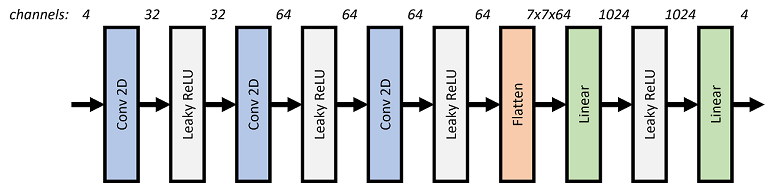

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.fc2 = nn.Linear(1024, 4)

        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')

    def forward(self, x):  # The input x has the shape [N, 4, 84, 84]
        x = F.leaky_relu(self.conv1(x), 0.01) # The output here has the shape [N, 32, 20, 20]
        x = F.leaky_relu(self.conv2(x), 0.01) # The output here has the shape [N, 64, 9, 9]
        x = F.leaky_relu(self.conv3(x), 0.01) # The output here has the shape [N, 64, 7, 7]
        x = F.leaky_relu(self.fc1(x.view(x.shape[0], -1)), 0.01)
        return self.fc2(x)

## C.2 - Q-learning optimization step

To avoid catastrophic forgetting, we will use a replay memory to sample past (state, action, reward) tuples `mem = TP08.Memory(max_size)`. The memory have three methods: `mem.store(state, action, reward, terminal)` to add a new element, `sample(N)` to return a mini-batch of N randomly sampled elements and `mem.size()` to return the size of the memory.

Write a function `optim_step(mem, model, target_model, optimizer)` that takes one mini-batch from the memory, and performs one step of the Q-learning algorithm on it. To do so, you need to:


1.   Sample a mini-batch $(S, S', A, R, T)$ of states, next_states, actions, rewards, and terminals from the memory.
2.   Compute a mask to remove terminal states from the training.
3.   Compute the approximate return using the `target_model` with `y = rewards + mask * GAMMA * torch.max(target_model(next_states), dim=1).values.view(-1, 1).detach()`
4.   Compute the Q-values given by the model (using `model`) for the current state $S$ to the selected action $A$.
5.   Use the smooth L1 loss to compare the model's Q-values and approximate returns.
6.   Clip the gradient to a maximum norm of 1, and perform one step of the optimizer.

In [ ]:
### YOUR CODE HERE ###

## C.3 - Full training loop
Initialize the memory, model, target_model (by copying the parameters of model using `target_model.load_state_dict(model.state_dict())`), and optimizer using Adam with a learning rate of 1e-4 and eps=1.5e-4.

In [ ]:
MEM_SIZE = int(1e5) # size of replay memory
EPISODES = int(1e3) # total training episodes
BATCH_SIZE = 32 # minibatch update size
GAMMA = 0.99 # discount factor
MODEL_UPDATE_EVERY = 4 # update model once every MODEL_UPDATE_EVERY frames
TARGET_UPDATE_EVERY = 1000 # update target once every TARGET_UPDATE_EVERY frames
WARMUP_PHASE = 20000 # number of frames before model and target updates begin
EPSILON_MIN = 0.1 # minimum epsilon greedy parameter during training
EPSILON_DESCREASE_DURATION = 1e5 # epsilon is linearly decreasing from 1 to EPSILON_MIN in EPSILON_DESCREASE_DURATION frames
TEST_EVERY = 100 # (episodes)
NUM_TEST = 5

num_frames = 0
### YOUR CODE HERE ###

Finally, write the testing and training loops by: reseting the environment, and applying the epsilon greedy `policy` on the preprocessed state at each iteration of the game. During training, you will need to store the states, actions, rewards and terminations in the memory, where a game is considered terminated if the game ended or if the user just lost a life.

In [ ]:
@torch.no_grad()
def test():
    print("[TESTING]")
    total_reward = 0
    policy = EpsilonGreedy(model, 0.01)

    for i in range(NUM_TEST):
        ### YOUR CODE HERE ###

    total_reward /= NUM_TEST
    print(f"[TESTING] Total Reward: {total_reward:.1f}")

def train(episode, num_frames):
    epsilon = max(EPSILON_MIN, 1 - (1 - EPSILON_MIN) * num_frames / EPSILON_DESCREASE_DURATION)
    policy = EpsilonGreedy(model, epsilon)
    ### YOUR CODE HERE ###

    while not done:
        ### YOUR CODE HERE ###

        if num_frames < WARMUP_PHASE:
            continue

        if num_frames % MODEL_UPDATE_EVERY == 0:
            optim_step(mem, model, target_model, optimizer)

        if num_frames % TARGET_UPDATE_EVERY == 0:
            target_model.load_state_dict(model.state_dict())

    print(f"[EPISODE {episode}] Total Reward: {total_reward:.1f}, Frames: {num_frames - num_frames_start}, Epsilon: {epsilon:.2f}, Total Frames: {num_frames}, Memory Size: {mem.size()}")
    return num_frames

for episode in range(EPISODES):
    num_frames = train(episode, num_frames)
    if episode % TEST_EVERY == 0:
        test()

Create a video of the new agent playing Breakout. How is the agent performing?

In [ ]:
### YOUR CODE HERE ###